# Exercise 10 - Question Answering in NLP
In this exercise, you will experiment with one of NLP’s exciting tasks - Question Answering!

You will first evaluate a pre-trained model on Squad, a leading question-answering dataset, and evaluate its performance. Those with an approved access to GPUs in AWS or a different provider are encouraged to also fine-tune a base model on the Squad dataset.

We will use HuggingFace’s Transformers, the leading package for NLP tasks using transformers. Your code should roughly follow the code of [this guide](https://huggingface.co/docs/transformers/tasks/question_answering) and [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/question_answering.ipynb).  

(**Important Note:** The guide writes considerable amount of code to handle the case of context longer than the max input sequence. For simplicity, in your code, you should remove from the datasets all contexts longer than 
`max_length = 384`)


### Experiment Tracking using ClearML
This exercise utilizes large models. While we only fine-tune existing models, the time required for fine-tuning is still large (over one hour of run on a V100 GPU in many cases). You are not expected to make many runs yourself, but we would like to benefit from the joint work of the entire class, and will therefore report our runs to ClearML.

We will use a shared ClearML project for all student groups, so you can see runs of other teams (see instructions below). Specifically, we will choose a set of hyper-parameters for your own runs, and compare them to others, so we benefit from the community runs.


Install the transformers, datasets libraries

In [ ]:
! pip install datasets transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import required libraries.  
Make sure your version of Transformers is at least 4.11.0.

In [ ]:
# Generic imports
import numpy as np
import pandas as pd
import tensorflow as tf
import collections
from torch.utils.data import DataLoader


# HuggingFace imports
from transformers import (
    AutoTokenizer,
    TFAutoModelForQuestionAnswering,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    default_data_collator,
)
from datasets import load_dataset, load_metric

# Validating transformers setup
import transformers

print(transformers.__version__)

4.19.2


We will use the 🤗 [Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions load_dataset and load_metric.

For our example here, we'll use version 1.1 of Stanford's [SQUAD dataset](https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/). 

Load the Squad v1.1 dataset.

In [3]:
datasets = load_dataset("squad")

Reusing dataset squad (/root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


  0%|          | 0/2 [00:00<?, ?it/s]

### Getting to know the dataset

The datasets object itself is DatasetDict, which contains one key for the training, validation and test set.

In [4]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

We can see the training, validation and test sets all have a column for the context, the question and the answers to those questions.

To access an actual element, you need to select a split first, then give an index:

In [5]:
datasets["train"][0]

{'answers': {'answer_start': [515], 'text': ['Saint Bernadette Soubirous']},
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'id': '5733be284776f41900661182',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'title': 'University_of_Notre_Dame'}

Now, answer these questions:  

What is the shortest context in the training dataset?


In [6]:
min([len(d.get("context")) for d in datasets["train"]])

151

What is the longest answer in the dataset?

In [ ]:
# Lets see first what is the max size of the text array under answers
max([len(d.get("answers").get("text")) for d in datasets["train"]])

1

This means that each question only got a single textual answer in the 'text' array.

Let's evaluate the max answer length:

In [ ]:
max([len(d.get("answers").get("text")[0]) for d in datasets["train"]])

239

Is there a question that appears multiple times? What is the most common question?

In [9]:
questions = pd.Series([d.get("question") for d in datasets["train"]])
questions.value_counts()

Who won this season of Idol?                                                                                  6
Which Caribbean nation is in the top quartile of HDI (but missing IHDI)?                                      6
I couldn't could up with another question. But i need to fill this space because I can't submit the hit.      6
Who was a pop idol that started on American Idol?                                                             5
dd                                                                                                            4
                                                                                                             ..
What were there periods of during the Triassic?                                                               1
Because of distance form the sea and wide variance in temperatures, what was the interior of Pangaea like?    1
What could have made temperatures more extreme?                                                         

### Getting to know the HuggingFace transformers’ tokenizers
As a preprocessing step, the HuggingFace code tokenizes input sequences using a Tokenizer. Read more about tokenizers here:
https://huggingface.co/docs/tokenizers/pipeline  
https://huggingface.co/transformers/v3.0.2/preprocessing.html

For this question, use the BERT tokenizer. The tokenizer sometimes breaks words into smaller chunks, so the number of tokens can be larger than the number of words. 

Using the first 1,000 context datapoints, print the 30 most common tokens by the tokenizer.


In [ ]:
model_name = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [ ]:
max_length = 384  # The maximum length of a feature (question and context)
doc_stride = 128  # The authorized overlap between two part of the context when splitting it is needed.


In [ ]:
for i, example in enumerate(datasets["train"]):
    if (
        len(tokenizer(example["question"], example["context"])["input_ids"])
        > max_length
    ):
        break
example = datasets["train"][i]
example

{'answers': {'answer_start': [30], 'text': ['over 1,600']},
 'context': "The men's basketball team has over 1,600 wins, one of only 12 schools who have reached that mark, and have appeared in 28 NCAA tournaments. Former player Austin Carr holds the record for most points scored in a single game of the tournament with 61. Although the team has never won the NCAA Tournament, they were named by the Helms Athletic Foundation as national champions twice. The team has orchestrated a number of upsets of number one ranked teams, the most notable of which was ending UCLA's record 88-game winning streak in 1974. The team has beaten an additional eight number-one teams, and those nine wins rank second, to UCLA's 10, all-time in wins against the top team. The team plays in newly renovated Purcell Pavilion (within the Edmund P. Joyce Center), which reopened for the beginning of the 2009–2010 season. The team is coached by Mike Brey, who, as of the 2014–15 season, his fifteenth at Notre Dame, has ac

In [13]:
len(tokenizer(example["question"], example["context"])["input_ids"])

400

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride,
)
tokenized_example

{'input_ids': [[101, 1731, 1242, 4646, 1674, 1103, 10360, 8022, 1441, 112, 188, 3163, 1264, 1138, 136, 102, 1109, 1441, 112, 188, 3163, 1264, 1144, 1166, 122, 117, 4372, 4646, 117, 1141, 1104, 1178, 1367, 2126, 1150, 1138, 1680, 1115, 4551, 117, 1105, 1138, 1691, 1107, 1743, 5089, 8446, 119, 6963, 1591, 5202, 12639, 3486, 1103, 1647, 1111, 1211, 1827, 2297, 1107, 170, 1423, 1342, 1104, 1103, 2348, 1114, 5391, 119, 1966, 1103, 1264, 1144, 1309, 1281, 1103, 5089, 5629, 117, 1152, 1127, 1417, 1118, 1103, 1124, 13505, 1116, 6244, 2974, 1112, 1569, 5461, 3059, 119, 1109, 1264, 1144, 26383, 170, 1295, 1104, 5737, 1116, 1104, 1295, 1141, 3616, 1929, 117, 1103, 1211, 3385, 1104, 1134, 1108, 3830, 12553, 112, 188, 1647, 5385, 118, 1342, 2183, 9192, 1107, 2424, 119, 1109, 1264, 1144, 7425, 1126, 2509, 2022, 1295, 118, 1141, 1929, 117, 1105, 1343, 2551, 4646, 3997, 1248, 117, 1106, 12553, 112, 188, 1275, 117, 1155, 118, 1159, 1107, 4646, 1222, 1103, 1499, 1264, 119, 1109, 1264, 2399, 1107, 3599, 

In [15]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] How many wins does the Notre Dame men's basketball team have? [SEP] The men's basketball team has over 1, 600 wins, one of only 12 schools who have reached that mark, and have appeared in 28 NCAA tournaments. Former player Austin Carr holds the record for most points scored in a single game of the tournament with 61. Although the team has never won the NCAA Tournament, they were named by the Helms Athletic Foundation as national champions twice. The team has orchestrated a number of upsets of number one ranked teams, the most notable of which was ending UCLA's record 88 - game winning streak in 1974. The team has beaten an additional eight number - one teams, and those nine wins rank second, to UCLA's 10, all - time in wins against the top team. The team plays in newly renovated Purcell Pavilion ( within the Edmund P. Joyce Center ), which reopened for the beginning of the 2009 – 2010 season. The team is coached by Mike Brey, who, as of the 2014 – 15 season, his fifteenth at Notr

In [ ]:
# Let's collect the context tokens from the first 1000 samples and count them
context_tokens = []

for i, sample in enumerate(datasets["train"]):
    tokenized_context = tokenizer.encode(sample["context"])
    context_tokens.extend(tokenized_context)
    if i == 1000:
        break

context_tokens_series = pd.Series(context_tokens)
context_tokens_series.value_counts()

117      10539
1103      8436
119       7412
1105      4633
107       4406
         ...  
3820         4
6665         4
21779        4
25045        4
15673        4
Length: 4350, dtype: int64

In [ ]:
top_30_tokens = [
    tokenizer.decode([t])
    for t in context_tokens_series.value_counts().head(30).index.tolist()
]
top_30_tokens

[',',
 'the',
 '.',
 'and',
 '"',
 'of',
 'in',
 'a',
 'Beyoncé',
 "'",
 'to',
 's',
 '-',
 'her',
 'The',
 'for',
 'on',
 'was',
 'with',
 'as',
 '[SEP]',
 'at',
 '[CLS]',
 'In',
 'by',
 'she',
 '(',
 ')',
 'that',
 'is']

### Load a pretrained Question Answering model
In this section, you will use a model pretrained on the Squad dataset for question answering.  

Choose a model you'd like to use.  
You can see a list of available models here: https://huggingface.co/models?dataset=dataset:squad&sort=downloads


Load the model.

In [ ]:
model_name_pretrained_squad = "distilbert-base-cased-distilled-squad"  # Choosing distilBERT, cased, pretrained on squad dataset
pretrained_model = TFAutoModelForQuestionAnswering.from_pretrained(
    model_name_pretrained_squad
)  # Loading pretrained model for question answering
pretrained_tokenizer = AutoTokenizer.from_pretrained(model_name_pretrained_squad)

All model checkpoint layers were used when initializing TFDistilBertForQuestionAnswering.

All the layers of TFDistilBertForQuestionAnswering were initialized from the model checkpoint at distilbert-base-cased-distilled-squad.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForQuestionAnswering for predictions without further training.


In [ ]:
# We define a preprocessing function to apply on the datasets to truncate and map the start and end tokens of the answer to the context
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = pretrained_tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs


def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = pretrained_tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs


In [6]:
train_dataset = datasets["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=datasets["train"].column_names,
)

validation_dataset = datasets["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=datasets["validation"].column_names,
)

print("Train sets sizes (raw vs. preprocesses):")
print(len(datasets["train"]), len(train_dataset))

print("Val sets sizes (raw vs. preprocesses):")
print(len(datasets["validation"]), len(validation_dataset))

Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-f714a690ef2233b7.arrow


  0%|          | 0/11 [00:00<?, ?ba/s]

Train sets sizes (raw vs. preprocesses):
87599 88729
Val sets sizes (raw vs. preprocesses):
10570 10822


In [7]:
# Let's predict on 100 examples of the eval set samples and eval the results
small_eval_set = datasets["validation"].select(range(100))

eval_set = small_eval_set.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=datasets["validation"].column_names,
)


eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model.set_format("numpy")

batch = {k: eval_set_for_model[k] for k in eval_set_for_model.column_names}
outputs = pretrained_model(**batch)

start_logits = outputs.start_logits.numpy()
end_logits = outputs.end_logits.numpy()

Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-bc0e4ac72682fcc6.arrow


In [8]:
eval_set_for_model

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 100
})

In [ ]:
# Now, we need to find the predicted answer for each example in our small_eval_set.
# One example may have been split into several features in eval_set, so the first step is to map each example in
# small_eval_set to the corresponding features in eval_set:
import collections

example_to_features = collections.defaultdict(list)
for idx, feature in enumerate(eval_set):
    example_to_features[feature["example_id"]].append(idx)

With this in hand, we can really get to work by looping through all the examples and, for each example, through all the associated features. As we said before, we’ll look at the logit scores for the n_best start logits and end logits, excluding positions that give:

* An answer that wouldn’t be inside the context
* An answer with negative length
* An answer that is too long (we limit the possibilities at max_answer_length=30)

Once we have all the scored possible answers for one example, we just pick the one with the best logit score:

In [ ]:
import numpy as np

n_best = 20
max_answer_length = 30
predicted_answers = []

for example in small_eval_set:
    example_id = example["id"]
    context = example["context"]
    answers = []

    for feature_index in example_to_features[example_id]:
        start_logit = start_logits[feature_index]
        end_logit = end_logits[feature_index]
        offsets = eval_set["offset_mapping"][feature_index]

        start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
        end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
        for start_index in start_indexes:
            for end_index in end_indexes:
                # Skip answers that are not fully in the context
                if offsets[start_index] is None or offsets[end_index] is None:
                    continue
                # Skip answers with a length that is either < 0 or > max_answer_length.
                if (
                    end_index < start_index
                    or end_index - start_index + 1 > max_answer_length
                ):
                    continue

                answers.append(
                    {
                        "text": context[
                            offsets[start_index][0] : offsets[end_index][1]
                        ],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                )

    best_answer = max(answers, key=lambda x: x["logit_score"])
    predicted_answers.append({"id": example_id, "prediction_text": best_answer["text"]})

In [11]:
theoretical_answers = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in small_eval_set
]

In [ ]:
# Let's print some predictions vs. labels
for i in range(10):
    print(
        f"Sample ID: {i}\nModel answer:{predicted_answers[i]}\nLabelers answer:{theoretical_answers[i]}\n"
    )

Sample ID: 0
Model answer:{'id': '56be4db0acb8001400a502ec', 'prediction_text': 'Denver Broncos'}
Labelers answer:{'id': '56be4db0acb8001400a502ec', 'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}}

Sample ID: 1
Model answer:{'id': '56be4db0acb8001400a502ed', 'prediction_text': 'Carolina Panthers'}
Labelers answer:{'id': '56be4db0acb8001400a502ed', 'answers': {'text': ['Carolina Panthers', 'Carolina Panthers', 'Carolina Panthers'], 'answer_start': [249, 249, 249]}}

Sample ID: 2
Model answer:{'id': '56be4db0acb8001400a502ee', 'prediction_text': "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California"}
Labelers answer:{'id': '56be4db0acb8001400a502ee', 'answers': {'text': ['Santa Clara, California', "Levi's Stadium", "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."], 'answer_start': [403, 355, 355]}}

Sample ID: 3
Model answer:{'id': '56be4db0acb8001400a502ef', 'prediction_text': 'Car

In [13]:
from datasets import load_metric

# Let's evaluate the metric for our sub sampled validation set
metric = load_metric("squad")
metric.compute(predictions=predicted_answers, references=theoretical_answers)

{'exact_match': 83.0, 'f1': 88.25000000000004}

Rather good considering that according to its paper DistilBERT fine-tuned on SQuAD obtains 79.1 and 86.9 for those scores on the whole dataset.

### Pretrained Model Error Analysis
Here you will evaluate your model’s performance.

Write code to manually review a few errors of the model. 


In [ ]:
for i in range(100):
    question = small_eval_set[i]["question"]
    context = small_eval_set[i]["context"]
    model_answers = predicted_answers[i]
    labelers_answers = theoretical_answers[i]

    if model_answers["prediction_text"] not in labelers_answers.get("answers").get(
        "text"
    ):
        print(
            f"Sample ID: {i}\nQuestion: {question}\nContext: {context}\nModel answer:{predicted_answers[i]}\nLabelers answer:{theoretical_answers[i]}\n"
        )

Sample ID: 2
Question: Where did Super Bowl 50 take place?
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Model answer:{'id': '56be4db0acb8001400a502ee', 'prediction_text': "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California"}
Labelers answe

Do you see a pattern there? Is there any hypothesis you form for cases where the model fails?

Yes, to me it seems taht the model makes mistaskes in questions that require some pre-knowledge that cannot be extracted from the context, and also in some overfitting to specific words, for example:

1. Who was the male singer who performed as a special guest during Super Bowl 50? It is clear that Bruno Mars is the male to the human readers but the model also adds Beyonce as the model cannot extract / understand the gender from the context.
2. At which Super Bowl did Beyonce headline the halftime show? I suspect that the model pherhabs did not see enough examples of greek numerics in texts when the question is numeric, therefor the only Supoerbowl + number he found in context was the answer he chose - The issue here is more "overfitting" to numbers vs. greek numerics.
3. How many times have the Panthers been in the Super Bowl? the model sees the words "eight appearances in the Super Bowl" and assumes it is the answer, this is probably due to overfitting to the answer "format" in other questions he saw.


Write code that runs inference and outputs the predicted answer to a context and question texts typed by the user. We recommend that you use ipywidgets for interactivity:  
https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html

Use the award-winning GUI you’ve just created, to try to manually poke holes in the model. Try to characterize the cases your model mishandles.


In [67]:
model_checkpoint = "distilbert-base-cased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/249M [00:00<?, ?B/s]

In [ ]:
import torch
import ipywidgets as widgets
from IPython.display import display

context_widget = widgets.Text(
    value="", placeholder="Type context", description="Context:", disabled=False
)
question_widget = widgets.Text(
    value="", placeholder="Type question", description="Question:", disabled=False
)

button = widgets.Button(
    description="Predict answer",
    disabled=False,
    button_style="",
    tooltip="Predict answer",
)


def print_prediction(val1, **kwargs):
    context = context_widget.value
    question = question_widget.value

    print(f"Question was: {question}")
    print(f"Context was: {context}")
    inputs = tokenizer(
        question,
        context,
        stride=128,
        max_length=384,
        padding="longest",
        truncation="only_second",
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
    )

    _ = inputs.pop("overflow_to_sample_mapping")
    offsets = inputs.pop("offset_mapping")

    inputs = inputs.convert_to_tensors("pt")

    outputs = model(**inputs)

    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    sequence_ids = inputs.sequence_ids()
    # Mask everything apart from the tokens of the context
    mask = [i != 1 for i in sequence_ids]
    # Unmask the [CLS] token
    mask[0] = False
    # Mask all the [PAD] tokens
    mask = torch.logical_or(torch.tensor(mask)[None], (inputs["attention_mask"] == 0))

    start_logits[mask] = -10000
    end_logits[mask] = -10000

    start_probabilities = torch.nn.functional.softmax(start_logits, dim=-1)
    end_probabilities = torch.nn.functional.softmax(end_logits, dim=-1)
    scores = start_probabilities[:, None] * end_probabilities[None, :]

    candidates = []
    for start_probs, end_probs in zip(start_probabilities, end_probabilities):
        scores = start_probs[:, None] * end_probs[None, :]
        idx = torch.triu(scores).argmax().item()

        start_idx = idx // scores.shape[0]
        end_idx = idx % scores.shape[0]
        score = scores[start_idx, end_idx].item()
        candidates.append((start_idx, end_idx, score))

    for candidate, offset in zip(candidates, offsets):
        start_token, end_token, score = candidate
        start_char, _ = offset[start_token]
        _, end_char = offset[end_token]
        answer = context[start_char:end_char]
        result = {
            "answer": answer,
            "start": start_char,
            "end": end_char,
            "score": score,
        }
        print(result)
        print()


button.on_click(print_prediction)

display(context_widget)
display(question_widget)
display(button)

Text(value='', description='Context:', placeholder='Type context')

Text(value='', description='Question:', placeholder='Type question')

Button(description='Predict answer', style=ButtonStyle(), tooltip='Predict answer')

Question was: What is the best sport?
Context was: Football is the best sport.
{'answer': 'Football', 'start': 0, 'end': 8, 'score': 0.9974584579467773}

Question was: What is the better, soccer or football?
Context was: Football is the best sport, but I think soccer is better.
{'answer': 'soccer', 'start': 40, 'end': 46, 'score': 0.4554733335971832}

Question was: Which male performer performed at the stadium?
Context was: Madona and Eminem performed at the stadium.
{'answer': 'Madona and Eminem', 'start': 0, 'end': 17, 'score': 0.6007322072982788}



One error that we see for example is that the model cannot answer questions that require pre-knowledge, for example, Madona is a female and Eminem is a male, but the model cannot understand that from the context and therfor predicts both of them as the male performer.

Next, evaluate your model’s performance for different lengths of input text and of answer length.

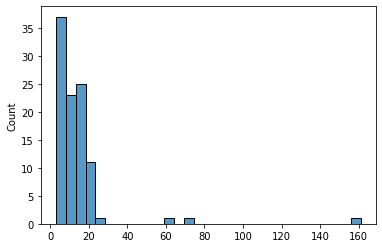

In [ ]:
import seaborn as sns

predictions_lengths = [len(i.get("prediction_text")) for i in predicted_answers]
sns.histplot(predictions_lengths)

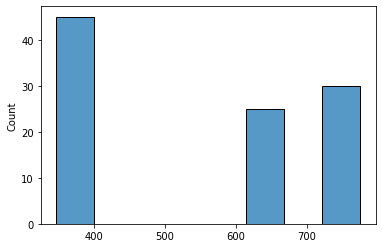

In [ ]:
context_lengths = [len(small_eval_set[i]["context"]) for i in range(100)]
sns.histplot(context_lengths)

In [ ]:
for i in range(100):
    question = small_eval_set[i]["question"]
    question_len = len(question)
    context = small_eval_set[i]["context"]
    context_len = len(context)
    model_answers = predicted_answers[i]
    labelers_answers = theoretical_answers[i]

    if model_answers["prediction_text"] not in labelers_answers.get("answers").get(
        "text"
    ):
        print(
            f"Sample ID: {i}\nQuestion: {question}\nContext: {context}\nModel answer:{predicted_answers[i]}\nLabelers answer:{theoretical_answers[i]}\n"
        )

# Let's evaluate the metric for our sub sampled validation set
metric = load_metric("squad")
metric.compute(predictions=predicted_answers, references=theoretical_answers)

Sample ID: 2
Question: Where did Super Bowl 50 take place?
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Model answer:{'id': '56be4db0acb8001400a502ee', 'prediction_text': "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California"}
Labelers answe

BONUS: Can you think of other axes that would be interesting to use to evaluate your model?

Yes, for example - clustering question types into categories (e.g. numeric / Noun extraction / Verb extraction / Name extraction), and evaluating the model per category or per category and question lengths.


### [Advanced] Fine-tune a Model
Here, you will fine-tune a base model to the Squad dataset, and evaluate its performance. 

Note that since the model is large, running this exercise might cost dozens of dollars. You’re very encouraged to use your AWS credits for that. We also recommend to work on the code on a cheap CPU-based machine, make sure that it runs properly, and then move to more expensive instances with GPUs for actual runs.

In [ ]:
base_model_name = "distilbert-base-cased"  # Choosing distilBERT, cased
batch_size = 16
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

In [6]:
# We define a preprocessing function to apply on the datasets to truncate and map the start and end tokens of the answer to the context
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs


In [ ]:
# Tokenizing the datasets
tokenized_squad = datasets.map(
    preprocess_function, batched=True, remove_columns=datasets["train"].column_names
)

Loading cached processed dataset at /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-0fc321ac25239730.arrow


  0%|          | 0/11 [00:00<?, ?ba/s]

In [ ]:
finetune_model = AutoModelForQuestionAnswering.from_pretrained(
    base_model_name
)  # Loading pretrained model for question answering

PARAM_LEARNING_RATE = 2e-5
PARAM_TRAIN_EPOCHS = 3
PARAM_WEIGHT_DECAY = 0.01

# Setting the training args
data_collator = default_data_collator

training_args = TrainingArguments(
    f"{base_model_name}-finetuned-squad",
    evaluation_strategy="epoch",
    learning_rate=PARAM_LEARNING_RATE,  # Low LR for fine-tuning
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=PARAM_TRAIN_EPOCHS,
    weight_decay=PARAM_WEIGHT_DECAY,
)

trainer = Trainer(
    model=finetune_model,
    args=training_args,
    train_dataset=tokenized_squad["train"],
    eval_dataset=tokenized_squad["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on

Train the model to fine-tune on the dataset. 

Make sure you use ClearML to report your results in real-time.

In [9]:
!pip install clearml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 794 kB 4.1 MB/s 


In [10]:
!clearml-init

ClearML SDK setup process

Please create new clearml credentials through the settings page in your `clearml-server` web app (e.g. http://localhost:8080//settings/workspace-configuration) 
Or create a free account at https://app.clear.ml/settings/workspace-configuration

In settings page, press "Create new credentials", then press "Copy to clipboard".

Paste copied configuration here:
api {      # Y-DATA program's workspace     web_server: https://app.clear.ml     api_server: https://api.clear.ml     files_server: https://files.clear.ml     credentials {         "access_key" = "67C5TL7VWEWIRZ5IHNZH"         "secret_key" = "YYDBzUicSb9hXO7d0hlFxzTmhmxsyIrwfaJNnhYssxaq7VDFjo"     } }
Detected credentials key="67C5TL7VWEWIRZ5IHNZH" secret="YYDB***"
WEB Host configured to: [https://app.clear.ml] 
API Host configured to: [https://api.clear.ml] 
File Store Host configured to: [https://files.clear.ml] 

ClearML Hosts configuration:
Web App: https://app.clear.ml
API: https://api.clear.ml
File S

In [ ]:
from clearml import Task

task = Task.init(project_name="ex10_asaf_and_omer", task_name="ex10")
task.connect(
    {
        "lr": PARAM_LEARNING_RATE,
        "epochs": PARAM_TRAIN_EPOCHS,
        "weight_decay": PARAM_WEIGHT_DECAY,
    }
)

ClearML Task: created new task id=1ac5ad67f75d44e28704bb7ff2fc19e9
2022-06-02 14:33:58,541 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/fb3590d4962846b5836285e9099f7ef3/experiments/1ac5ad67f75d44e28704bb7ff2fc19e9/output/log


{'epochs': 3, 'lr': 2e-05, 'weight_decay': 0.01}

In [12]:
# Run the training
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning

***** Running training *****
  Num examples = 87599
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16425


Epoch,Training Loss,Validation Loss
1,1.200600,1.168898
2,0.958600,1.109911
3,0.744800,1.137528


Saving model checkpoint to distilbert-base-cased-finetuned-squad/checkpoint-500
Configuration saved in distilbert-base-cased-finetuned-squad/checkpoint-500/config.json
Model weights saved in distilbert-base-cased-finetuned-squad/checkpoint-500/pytorch_model.bin
tokenizer config file saved in distilbert-base-cased-finetuned-squad/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-cased-finetuned-squad/checkpoint-500/special_tokens_map.json
Saving model checkpoint to distilbert-base-cased-finetuned-squad/checkpoint-1000
Configuration saved in distilbert-base-cased-finetuned-squad/checkpoint-1000/config.json
Model weights saved in distilbert-base-cased-finetuned-squad/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in distilbert-base-cased-finetuned-squad/checkpoint-1000/tokenizer_config.json
Special tokens file saved in distilbert-base-cased-finetuned-squad/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to distilbert-base-case

TrainOutput(global_step=16425, training_loss=1.0880714061162242, metrics={'train_runtime': 6690.0625, 'train_samples_per_second': 39.282, 'train_steps_per_second': 2.455, 'total_flos': 2.575143204683213e+16, 'train_loss': 1.0880714061162242, 'epoch': 3.0})

In [13]:
trainer.save_model("finetuned-squad")

Saving model checkpoint to finetuned-squad
Configuration saved in finetuned-squad/config.json
Model weights saved in finetuned-squad/pytorch_model.bin
tokenizer config file saved in finetuned-squad/tokenizer_config.json
Special tokens file saved in finetuned-squad/special_tokens_map.json


Write below your train and validation loss. You can compare your results to those of others from the class using ClearML.

In [ ]:
# Epoch 1 - Train loss: 1.200600 - Validation loss: 1.168898
# Epoch 2 - Train loss: 0.958600 - Validation loss: 1.109911
# Epoch 3 - Train loss: 0.744800 - Validation loss: 1.137528

This is how the training looks in clearml:

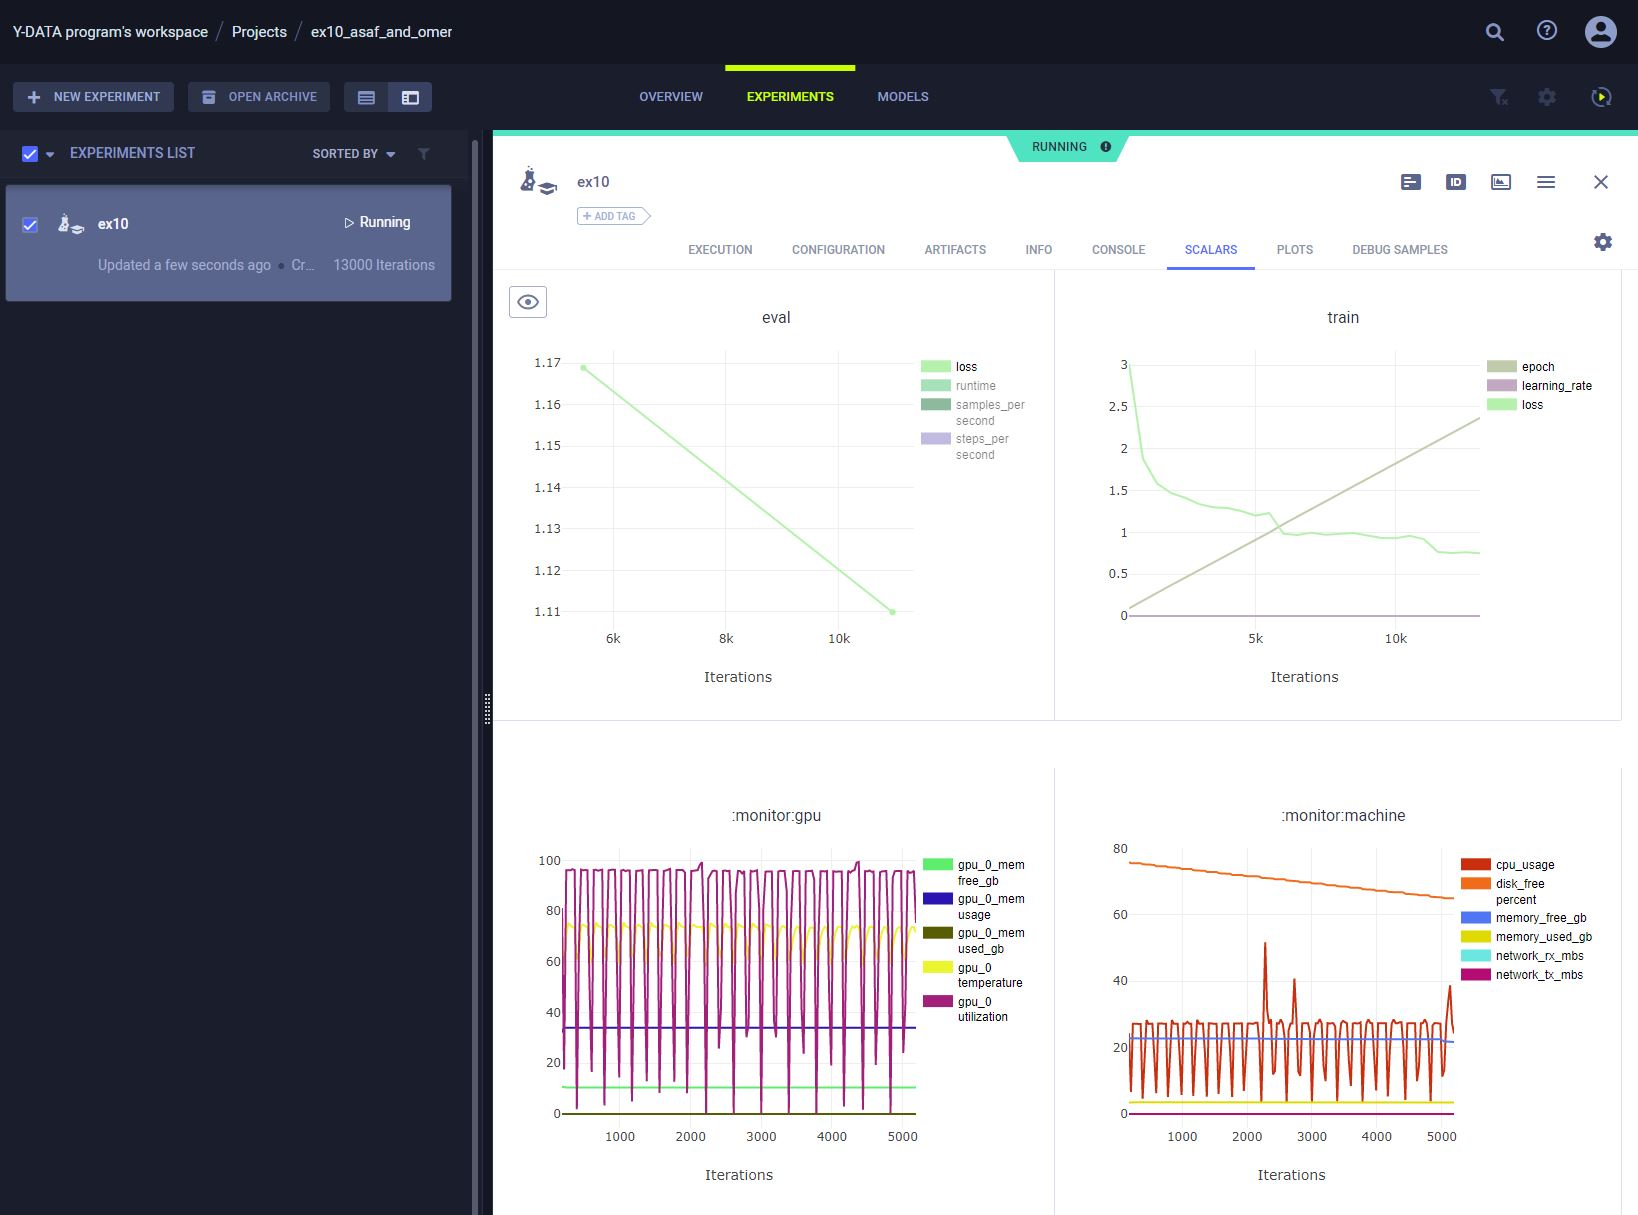

## ClearML Integration
You can join the ClearML slack channel at  https://join.slack.com/t/clearml/shared_invite/zt-c0t13pty-aVUZZW1TSSSg2vyIGVPBhg to ask questions and see real life examples and questions of industry users.

### Parameters & Configurations
Keep your parameters/configs in a single dict within your code. For example 

`config={"param":"data", ...}`

This way you can easily connect into clearml using

`Task.connect(config)`

The documentation is here:
https://clear.ml/docs/latest/docs/references/sdk/task#connect_configuration


### Comparisons
Once you gathered some data, you can select multiple experiments and compare them, as detailed here: https://clear.ml/docs/latest/docs/webapp/webapp_exp_comparing/

### Additional Videos
We also recommend you review these videos to learn industry best practices:
- Day in the life of a data scientist - This video will cover nearly everything your might need to use clearml - https://www.youtube.com/watch?v=quSGXvuK1IM
- Detection in video on raspberry pi – a real world example of what can be done with ML (an example of a nice portfolio project) -  https://www.youtube.com/watch?v=ZiOr9EdYEeE


## Recommended Resources
For an open discussion on Question Answering related topics, you are very encouraged to watch this workshop: https://www.youtube.com/watch?v=Ihgk8kGLpIE

This screencast uses T5 on a different Q&A dataset: https://www.youtube.com/watch?v=_l2wJb3QPdk

That's it, good luck!